In [1]:
import MDAnalysis
import numpy
import networkx
import matplotlib.pyplot
import pandas
import re

/home/flg/Programs/anaconda3/envs/mdana/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load fingerprint data for all ligands (guests)

c = pandas.read_csv("/home/flg/Simulations/fp/figures_paper/revision/fp_selection_automization/ranking.csv", header=[0])

In [ ]:
def load_mol(mol:str):
    # load connectivity information form tpr file 
    u = MDAnalysis.Universe(mol+'.tpr')
    # select heavy atoms
    ha = u.select_atoms("resname MOL and not (name H*)")

    # create graph of heavy atoms 

    G = networkx.Graph()

    # add heavy atoms as nodes
    for atom in ha:
        G.add_node(atom.index, element=atom.name) #extract element form atom name: re.search(r'(\D+)', atom.name).group(1)
    for bond in ha.bonds:
        # only add edges between heavy atoms (ignoring hydrogens)
        if bond.atoms[0].index in G.nodes and bond.atoms[1].index in G.nodes:
            G.add_edge(bond.atoms[0].index, bond.atoms[1].index)

    return u, ha, G

def path_length(atom1, atom2, G):
    try:
        length = networkx.shortest_path_length(G, source=atom1.index, target=atom2.index)
    except networkx.NetworkXNoPath:
        print(f"No path between {atom1.index} and {atom2.index}")
        length = None
    return length

def ranking(mol:str):
    data = c[c['name'] == mol].sort_values('fp')
    return data

def select_next_atom(mol:str, verbose=True):

    data = ranking(mol)
    u, ha, G = load_mol(mol.split('-')[0]+mol.split('-')[1])

    """
    Walk through the fp-sorted table and select the anti-bulk fp atoms.
    
    Rules:
      - First atom is always the first row in the table
      - Reject atoms directly connected to the first selected atom (path = 1)
      - Compare atoms with fp_round difference < 0.2
      - Among atoms with equal fp, pick the atom with the longest path
      - Loop through the entire table, until the fp_round difference is not < 0.2   
    """

    # first atom is always the first row in the table
    # zero-index in MDAnalysis, one-index in .gro, used for ranking dataframe    

    anchor_idx = int(data.iloc[0]['atom']) - 1
    anchor_atom = ha[anchor_idx]

    if verbose:
        print(f"Highest-ranking atom: {anchor_atom.name} ({int(anchor_atom.index+1)}) with fp_round {data.iloc[0]['fp_round']}")

    # continue with second entry in the table

    i = 1
    winner = None
    l_win = -1

    # check if there are more than 2 atoms with identical fp_round as anchor
    if data[data['fp_round']==data.iloc[0]['fp_round']].count().values[0]>2:
        if verbose:
            print(">2 atoms with identical fp_round as highest-ranking atom -> ambiguous choice")
        return None
    while i < len(data):
        cand_idx = int(data.iloc[i]['atom']) - 1
        cand_atom = ha[cand_idx]
        l_cand = path_length(cand_atom, anchor_atom, G)

        if l_cand <= 1:
            if verbose:
                print(f"{i}: {cand_atom.name} connected to {anchor_atom.name} -> rejected")
            i += 1
            continue

        if winner is None:
            winner = cand_atom
            l_win = l_cand
            fp_win = float(data.iloc[i]['fp_round'])
        else:
            fp_cand = float(data.iloc[i]['fp_round'])

            if abs(fp_cand - fp_win) < 0.2:
                
                # candidate is in close fp group
                if l_cand > l_win:
                    if verbose:
                        print(f"{i}: {cand_atom.name} beats {winner.name} (longer path {l_cand} > {l_win})")
                    winner, l_win, fp_win = cand_atom, l_cand, fp_cand
                elif l_cand == l_win:
                    if verbose:
                        print(f"{i}: {cand_atom.name} and {winner.name} are equidistant and have same fp -> choose either")
                        if abs(float(data.iloc[i]['fp_round'])) < 2.0:
                            print("Warning: Very low fingerprint value!")
                    break
                else:
                    if verbose:
                        print(f"{i}: {cand_atom.name} shorter path than {winner.name} -> ignored")

        i += 1

    return f"anti-bulk fp selection: {anchor_atom.name} ({int(anchor_atom.index+1)}), {winner.name} ({int(winner.index+1)})"

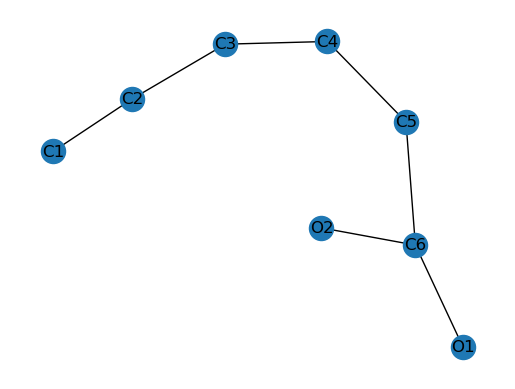

In [20]:
u, ha, G = load_mol('S5G1')
fig, ax = matplotlib.pyplot.subplots()
networkx.draw(G, ax=ax, labels={n: G.nodes[n]['element'] for n in G.nodes}, with_labels=True)


In [21]:
select_next_atom('S6-G2', verbose=True)

Highest-ranking atom: C9 (9) with fp_round -3.4
1: C5 connected to C9 -> rejected
2: C8 connected to C9 -> rejected
3: C6 connected to C9 -> rejected
5: C2 shorter path than C4 -> ignored
6: C7 shorter path than C4 -> ignored


/home/flg/Programs/anaconda3/envs/mdana/lib/python3.13/site-packages/MDAnalysis/core/universe.py:150: UserWarning: No coordinate reader found for S6G2.tpr. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


'anti-bulk fp selection: C9 (9), C4 (4)'

In [62]:
def select_bulk_atom(mol:str, verbose=True):

    data = ranking(mol)
    u, ha, G = load_mol(mol.split('-')[0]+mol.split('-')[1])

    """
    Walk through the fp-sorted table and select the anti-bulk fp atoms.
    
    Rules:
      - First atom is always the first row in the table
      - Reject atoms directly connected to the first selected atom (path = 1)
      - Compare atoms with fp_round difference < 0.2
      - Among atoms with equal fp, pick the atom with the longest path
      - Loop through the entire table, until the fp_round difference is not < 0.2   
    """

    # first atom is always the last row in the table
    # zero-index in MDAnalysis, one-index in .gro, used for ranking dataframe    

    anchor_idx = int(data.iloc[-1]['atom']) - 1
    anchor_atom = ha[anchor_idx]

    if verbose:
        print(f"Lowest-ranking atom: {anchor_atom.name} ({int(anchor_atom.index+1)}) with fp_round {data.iloc[-1]['fp_round']}")

    # continue with second entry from the bottom in the table

    i = - 2
    winner = None
    l_win = -1
    fp_win = float(data.iloc[i]['fp_round'])

    # check if there are more than 2 atoms with identical fp_round as anchor
    while abs(i) <= len(data):
        
        cand_idx = int(data.iloc[i]['atom']) - 1
        cand_atom = ha[cand_idx]
        l_cand = path_length(cand_atom, anchor_atom, G)
        fp_cand = float(data.iloc[i]['fp_round'])

        #if abs(fp_cand - fp_win) < 0.2:

        if l_cand <= 2:
            if verbose:
                print(f"{i}: {cand_atom.name} connected to {anchor_atom.name} -> rejected")
        else:
            if winner is None:
                winner = cand_atom
                l_win = l_cand
                break
            else:
                winner = cand_atom
                l_win = l_cand
                break 
                
            """ else:
                if l_cand > l_win:
                    if verbose:
                        print(f"{i}: {cand_atom.name} beats {winner.name} "
                              f"(longer path {l_cand} > {l_win})")
                    winner, l_win = cand_atom, l_cand
                elif l_cand == l_win:
                    if verbose:
                        print(f"{i}: {cand_atom.name} and {winner.name} are equidistant "
                              f"(path {l_cand}) -> choose either")
                else:
                    if verbose:
                        print(f"{i}: {cand_atom.name} shorter path than {winner.name} -> ignored")
 """
        i -= 1  # walk upward

    return f"bulk fp selection: {anchor_atom.name} ({int(anchor_atom.index+1)}), " \
           f"{winner.name} ({int(winner.index+1)})"

In [76]:
select_bulk_atom('S6-G7', verbose=True)

Lowest-ranking atom: C1 (1) with fp_round -1.8


/home/flg/Programs/anaconda3/envs/mdana/lib/python3.13/site-packages/MDAnalysis/core/universe.py:150: UserWarning: No coordinate reader found for S6G7.tpr. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


'bulk fp selection: C1 (1), O2 (9)'